## Part 1: Predicting Customer Churn using Neural Networks
### Objective: 
The objective of this assignment is to develop a deep learning model that can predict customer churn for a telecom company. You will use a dataset containing customer information, and whether or not the customer churned.

In [111]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import os
import pandas as pd

# for timing computations
import time

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
display.set_matplotlib_formats('svg')

import warnings
warnings.filterwarnings("ignore")

C:\Users\athorat\AppData\Local\Temp\ipykernel_15172\385740970.py:25: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


#### 2. Load the dataset and perform exploratory data analysis.

In [54]:
os.chdir('C:/Users/athorat/OneDrive - Nice Systems Ltd/00_Amit Thorat Data/ISB - AMPBA/01_Project/Term4_DL\Assignment\Part 1')
custData = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
custData.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [55]:
custData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


#### Univariate Analysis

<Axes: xlabel='Churn'>

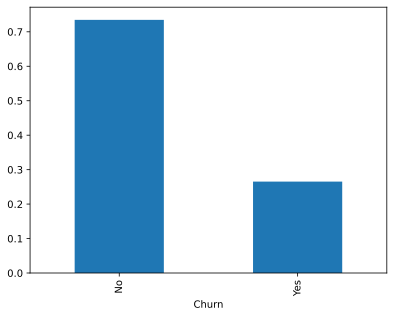

In [56]:
# Target Variable
custData.Churn.value_counts(normalize = True).plot(kind = "bar")

In [57]:
# Split the Customer ID
ids = []

for i in custData.customerID:
    ids.append(i.split("-")[1])

In [58]:
# Creating a New Column called Ids in the DataFrame.

custData["Ids"]=pd.Series(ids)

In [59]:
# Lets Analyse if the Ids Column is Statistically Significant or Not

# Ho: Ids & Churn are Independent of Each Other. It means that Ids has no Statistical relation with Churn
# Ha: Ids & Churn are Dependent on Each Other. It means that Ids has Statistical relation with Churn

tbl = pd.crosstab(custData["Ids"], custData.Churn)

import scipy.stats as stats
teststats, pvalue, dof, exp_freq = stats.chi2_contingency(tbl)
print("Pvalue: ", pvalue)

Pvalue:  0.492933486675262


Inference: Ids variable has no Statistical Significance with the Churn. We can drop the ID variable in the end.

In [60]:
# Lets Convert the Total Charges to Numerical...
custData["TotalCharges"] = pd.to_numeric(custData.TotalCharges, errors="coerce")

In [61]:
custData.MultipleLines.value_counts()

MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64

In [62]:
# MultipleLines: Assumes that No phone service means No
custData.MultipleLines.replace(to_replace="No phone service", value = "No", 
                         inplace = True)

In [63]:
# List of all Columns which need replacing
cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies']

In [64]:
# Loop for Replacement of text into No
for i in cols:
    custData.loc[:, i].replace(to_replace="No internet service", value = "No", 
                         inplace = True)

In [65]:
# Lets Split the DataFrame in two parts - Where the Churn==Yes & Where the Churn == No and analyse the Subsets.

yes = custData.loc[custData.Churn=="Yes"]
no = custData.loc[custData.Churn=="No"]

In [66]:
catCols = ['gender', 'Partner', 'Dependents', 'SeniorCitizen', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 
       'Churn']

In [67]:
signiFeats =[]
for i in catCols:
    tbl =pd.crosstab(custData.loc[:, i], custData.Churn)
    tstats, pval, dof, exp_freq = stats.chi2_contingency(tbl)
    if pval<0.05:
        print(i, ": Pvalue", pval)
        signiFeats.append(i)

Partner : Pvalue 2.1399113440759935e-36
Dependents : Pvalue 4.9249216612154196e-43
SeniorCitizen : Pvalue 1.510066805092378e-36
MultipleLines : Pvalue 0.0008433795342472428
InternetService : Pvalue 9.571788222840544e-160
OnlineSecurity : Pvalue 1.2320984831180025e-46
OnlineBackup : Pvalue 6.214092807254819e-12
DeviceProtection : Pvalue 3.315693222362861e-08
TechSupport : Pvalue 2.9235674453140758e-43
StreamingTV : Pvalue 1.3024835736732686e-07
StreamingMovies : Pvalue 2.9974738476267514e-07
Contract : Pvalue 5.863038300673391e-258
PaperlessBilling : Pvalue 4.073354668665985e-58
PaymentMethod : Pvalue 3.6823546520097993e-140
Churn : Pvalue 0.0


In [68]:
print("List of Significant Features: ", signiFeats)

List of Significant Features:  ['Partner', 'Dependents', 'SeniorCitizen', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']


C:\Users\athorat\AppData\Local\Temp\ipykernel_15172\51564694.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(yes.loc[:, i])
C:\Users\athorat\AppData\Local\anaconda3\envs\tf-new\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\athorat\AppData\Local\anaconda3\envs\tf-new\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating inste

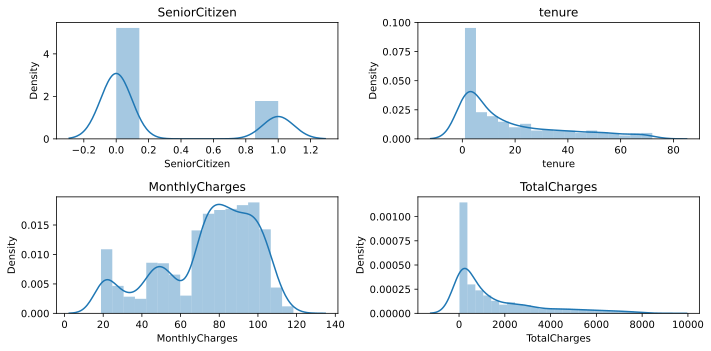

In [69]:
# Where the Churn == Yes
numCols = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
plt.figure(figsize = (10, 5))
nrows = 2
ncols = 2
iterator = 1
for i in numCols:
    plt.subplot(nrows, ncols, iterator)
    sns.distplot(yes.loc[:, i])
    plt.title(i)
    iterator+=1

plt.tight_layout()   
plt.show()

C:\Users\athorat\AppData\Local\Temp\ipykernel_15172\3886385785.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(no.loc[:, i])
C:\Users\athorat\AppData\Local\anaconda3\envs\tf-new\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\athorat\AppData\Local\anaconda3\envs\tf-new\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating inst

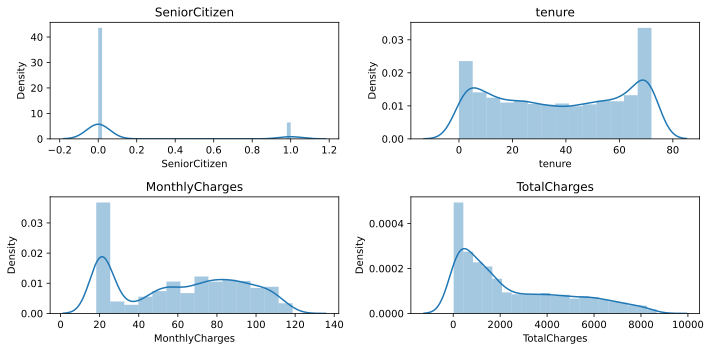

In [70]:
# Where the Churn == Yes

plt.figure(figsize = (10, 5))
nrows = 2
ncols = 2
iterator = 1
for i in numCols:
    plt.subplot(nrows, ncols, iterator)
    sns.distplot(no.loc[:, i])
    plt.title(i)
    iterator+=1

plt.tight_layout()  
plt.show()

In [71]:
yes.select_dtypes(include = np.number).describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,1869.000000,1869.000000,1869.000000,1869.000000
mean,0.254682,17.979133,74.441332,1531.796094
std,0.435799,19.531123,24.666053,1890.822994
min,0.000000,1.000000,18.850000,18.850000
25%,0.000000,2.000000,56.150000,134.500000
50%,0.000000,10.000000,79.650000,703.550000
75%,1.000000,29.000000,94.200000,2331.300000
max,1.000000,72.000000,118.350000,8684.800000


In [72]:
no.select_dtypes(include = np.number).describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,5174.000000,5174.000000,5174.000000,5163.000000
mean,0.128721,37.569965,61.265124,2555.344141
std,0.334923,24.113777,31.092648,2329.456984
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,15.000000,25.100000,577.825000
50%,0.000000,38.000000,64.425000,1683.600000
75%,0.000000,61.000000,88.400000,4264.125000
max,1.000000,72.000000,118.750000,8672.450000


In [73]:
# Statistical Test for Numerical Columns - T Test

for i in numCols:
    churnYes = custData.loc[custData.Churn=="Yes", i]
    churnNo = custData.loc[custData.Churn=="No", i]
    teststats, pvalue = stats.ttest_ind(churnYes, churnNo)
    if pvalue<0.05:
        print(i, ":Pvalue", pvalue)

SeniorCitizen :Pvalue 3.8398600557847846e-37
tenure :Pvalue 7.99905796059022e-205
MonthlyCharges :Pvalue 2.7066456068884154e-60


#### Bivariate Analysis

C:\Users\athorat\AppData\Local\anaconda3\envs\tf-new\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\athorat\AppData\Local\anaconda3\envs\tf-new\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\athorat\AppData\Local\anaconda3\envs\tf-new\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\athorat\AppData\Local\anaconda3\envs\tf-new\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated a

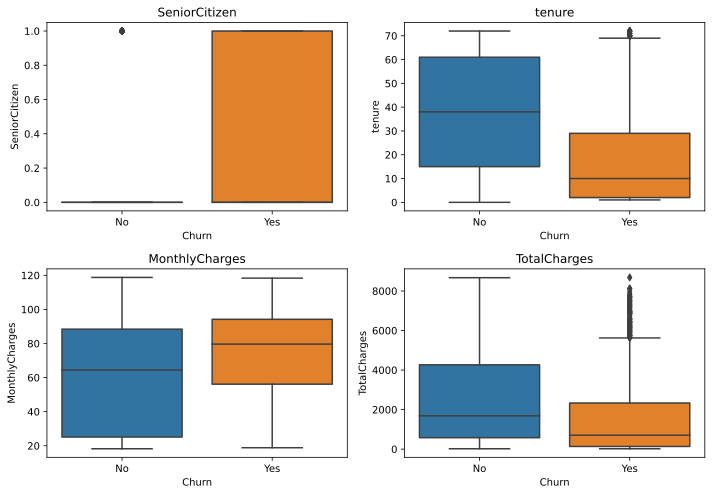

In [74]:
plt.figure(figsize = (10, 7))
nrows = 2
ncols = 2
iterator = 1
for i in numCols:
    plt.subplot(nrows, ncols, iterator)
    sns.boxplot(x=custData['Churn'], y=custData[i])
    plt.title(i)
    iterator+=1

plt.tight_layout()
plt.show()

In [75]:
custData.isnull().sum()[custData.isnull().sum()!=0]

TotalCharges    11
dtype: int64

In [76]:
custData.loc[custData.tenure==0]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Ids
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No,DSL,Yes,...,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No,LVYGI
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No,...,No,No,No,Two year,No,Mailed check,20.25,NaN,No,CZMZD
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No,LVOEQ
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No,...,No,No,No,Two year,No,Mailed check,25.75,NaN,No,NUYAO
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No,DSL,Yes,...,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No,DWPAZ
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No,...,No,No,No,Two year,No,Mailed check,19.85,NaN,No,OMVMY
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No,...,No,No,No,Two year,No,Mailed check,25.35,NaN,No,VVOLG
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No,...,No,No,No,Two year,No,Mailed check,20.00,NaN,No,SGTTA
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No,...,No,No,No,One year,Yes,Mailed check,19.70,NaN,No,ARZLG
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No,WKNIU


In [77]:
# Replacing the 0 tenure with 1

custData.loc[custData.tenure==0, "tenure"]=1

In [78]:
# Lets Print the Index of the Rows where the Total Charges is Missing

custData.loc[custData.TotalCharges.isnull()].index

Index([488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754], dtype='int64')

In [79]:
# Lets Create a DataFrame used for Dealing with Missing Values.

withoutMiss = custData.dropna()

In [80]:
# Lets Build a Linear Regression Model that will be used to Deal with the Missing values in TotalCharges Var.
from statsmodels.formula.api import ols

model = ols("TotalCharges~MonthlyCharges+tenure", data = withoutMiss).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           TotalCharges   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                 2.997e+04
Date:                Wed, 13 Sep 2023   Prob (F-statistic):               0.00
Time:                        22:17:28   Log-Likelihood:                -56382.
No. Observations:                7032   AIC:                         1.128e+05
Df Residuals:                    7029   BIC:                         1.128e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -2162.4319     21.990    -98.337      0.000   -2205.539   -2119.325
MonthlyCharges    35.8789      0.300    119.415      0.000      35.290      36.468
tenure            65.4141      0.368    177.622      0.000      64.692      66.136
==============================================================================
Omnibus:                       48.866   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.125
Skew:                           0.106   Prob(JB):                     3.19e-09
Kurtosis:                       2.702   Cond. No.                         198.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now, We will use the following equation to fill the Missing Values:

* **model.params[0]+model.params[1] * df["MonthlyCharges"]+model.params[2] * df["tenure"]**

In [87]:
# Fill the Missing Values for a Single Row....

custData.loc[144, "TotalCharges"] = np.abs(model.params[0]+\
model.params[1]*custData.loc[144, "MonthlyCharges"]+model.params[2]*custData.loc[144, "tenure"])

C:\Users\athorat\AppData\Local\Temp\ipykernel_15172\1845070930.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  custData.loc[144, "TotalCharges"] = np.abs(model.params[0]+\
C:\Users\athorat\AppData\Local\Temp\ipykernel_15172\1845070930.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model.params[1]*custData.loc[144, "MonthlyCharges"]+model.params[2]*custData.loc[144, "tenure"])


In [88]:
# Lets Fill the Missing Value for the Whole Set of Rows where the Total Charges is Missing...

for i in custData.loc[custData.TotalCharges.isnull()].index:
    custData.loc[i, "TotalCharges"] = np.abs(model.params[0]+\
    model.params[1]*custData.loc[i, "MonthlyCharges"] + model.params[2]*custData.loc[i, "tenure"])

In [89]:
# lets recheck if there are any missing values...

custData.loc[custData.TotalCharges.isnull()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Ids


#### 3. Pre-process the data by converting categorical variables to numerical variables, and scaling the data.

#### Feature Engineering

In [90]:
# Creating a New Feature Called Consolidated Charges & Other Charges

custData["ConsolidatedCharges"] = custData["tenure"]*custData["MonthlyCharges"]

custData["OtherCharges"] = np.abs(custData["ConsolidatedCharges"] - custData["TotalCharges"])

C:\Users\athorat\AppData\Local\anaconda3\envs\tf-new\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\athorat\AppData\Local\anaconda3\envs\tf-new\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\athorat\AppData\Local\anaconda3\envs\tf-new\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Churn', ylabel='OtherCharges'>

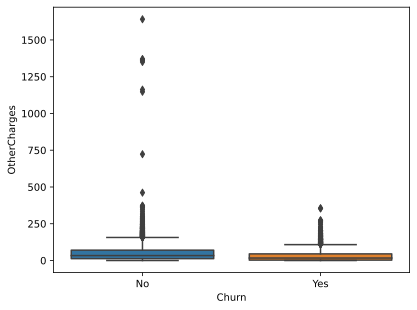

In [91]:
sns.boxplot(x = "Churn", y = "OtherCharges", data = custData)

#### Statistical Test of Charges vs Churn (Two Sample Independent T Test)

Lets now apply the Hypothesis Test on the Numerical Variables and find out which of these are Statistically Significant for the Model Building Purposes.

* **Ho: That the Churn & Total/Consolidated/OtherCharges Var is Independent i.e. Not Statistically Significant.**

* **Ha: That the Churn & Total/Consolidated/OtherCharges Var is Dependent i.e. Statistically Significant.**

In [92]:
yesChgs = custData.loc[custData.Churn=="Yes", "OtherCharges"]
noChgs = custData.loc[custData.Churn=="No", "OtherCharges"]

stats.ttest_ind(yesChgs, noChgs)

TtestResult(statistic=-10.236400941897497, pvalue=2.0185884086453224e-24, df=7041.0)

Result: The ``OtherCharges`` Variable is Statistically Significant.

In [93]:
yesChgs = custData.loc[custData.Churn=="Yes", "ConsolidatedCharges"]
noChgs = custData.loc[custData.Churn=="No", "ConsolidatedCharges"]

stats.ttest_ind(yesChgs, noChgs)

TtestResult(statistic=-16.997740714271874, pvalue=1.5594238433986466e-63, df=7041.0)

Result: The ``ConslidatedCharges`` Variable is Statistically Significant.

In [94]:
yesChgs = custData.loc[custData.Churn=="Yes", "TotalCharges"]
noChgs = custData.loc[custData.Churn=="No", "TotalCharges"]

stats.ttest_ind(yesChgs, noChgs)

TtestResult(statistic=-17.02423692124583, pvalue=1.0099462448361303e-63, df=7041.0)

Result: Now We see that ``TotalCharges`` is also a Significant Variable

**Lets Create a New DataFrame called 'Final' with Significant Features only**

In [95]:
finalCustData = custData.loc[:, signiFeats+["tenure", "MonthlyCharges", 
                       "ConsolidatedCharges", "TotalCharges", "OtherCharges"]]

In [96]:
finalCustData.head()

,Partner,Dependents,SeniorCitizen,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn,tenure,MonthlyCharges,ConsolidatedCharges,TotalCharges,OtherCharges
0,Yes,No,0,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,No,1,29.85,29.85,29.85,0.00
1,No,No,0,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,No,34,56.95,1936.30,1889.50,46.80
2,No,No,0,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,Yes,2,53.85,107.70,108.15,0.45
3,No,No,0,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),No,45,42.30,1903.50,1840.75,62.75
4,No,No,0,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,Yes,2,70.70,141.40,151.65,10.25


In [97]:
finalCustData.columns

Index(['Partner', 'Dependents', 'SeniorCitizen', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'Churn', 'tenure',
       'MonthlyCharges', 'ConsolidatedCharges', 'TotalCharges',
       'OtherCharges'],
      dtype='object')

#### Encoding Categorical Variables

In [116]:
cols = ['Partner', 'Dependents', 'MultipleLines',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 
       'PaperlessBilling', 'Churn']

#dictCoded={"Yes":1, "No":0}

for i in cols:
    finalCustData[i] = [1 if value == 'Yes' else 0 for value in finalCustData[i]]
    finalCustData[i] = finalCustData[i].astype(float)

In [118]:
finalCustData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Partner              7043 non-null   float64
 1   Dependents           7043 non-null   float64
 2   SeniorCitizen        7043 non-null   int64  
 3   MultipleLines        7043 non-null   float64
 4   InternetService      7043 non-null   int64  
 5   OnlineSecurity       7043 non-null   float64
 6   OnlineBackup         7043 non-null   float64
 7   DeviceProtection     7043 non-null   float64
 8   TechSupport          7043 non-null   float64
 9   StreamingTV          7043 non-null   float64
 10  StreamingMovies      7043 non-null   float64
 11  Contract             7043 non-null   int64  
 12  PaperlessBilling     7043 non-null   float64
 13  PaymentMethod        7043 non-null   int64  
 14  Churn                7043 non-null   float64
 15  tenure               7043 non-null   i

In [119]:
# Lets Check how to Encode the PaymentMethod

finalCustData.PaymentMethod.value_counts()

PaymentMethod
4    2365
3    1612
2    1544
1    1522
Name: count, dtype: int64

In [120]:
dictPay = {'Electronic check':4, 'Mailed check':3, 'Bank transfer (automatic)':2,'Credit card (automatic)':1}

finalCustData["PaymentMethod"] = finalCustData["PaymentMethod"].map(dictPay)

In [121]:
# Lets Check how to Encode the Contract
finalCustData.Contract.value_counts()

Contract
3    3875
2    1695
1    1473
Name: count, dtype: int64

In [122]:
# Encoding Contract
dictPay = {'Month-to-month':3, 'Two year':2, 'One year':1}

finalCustData["Contract"] = finalCustData["Contract"].map(dictPay)

In [123]:
# Lets Check how to Encode the Internet Service
finalCustData["InternetService"].value_counts()

InternetService
3    3096
2    2421
1    1526
Name: count, dtype: int64

In [124]:
# Encoding InternetService
dictPay = {'Fiber optic':3, 'DSL':2, 'No':1}

finalCustData["InternetService"] = finalCustData["InternetService"].map(dictPay)

In [125]:
finalCustData.head()

,Partner,Dependents,SeniorCitizen,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn,tenure,MonthlyCharges,ConsolidatedCharges,TotalCharges,OtherCharges
0,0.0,0.0,0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,1,29.85,29.85,29.85,0.00
1,0.0,0.0,0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,34,56.95,1936.30,1889.50,46.80
2,0.0,0.0,0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,2,53.85,107.70,108.15,0.45
3,0.0,0.0,0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,45,42.30,1903.50,1840.75,62.75
4,0.0,0.0,0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,2,70.70,141.40,151.65,10.25


In [126]:
finalCustData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Partner              7043 non-null   float64
 1   Dependents           7043 non-null   float64
 2   SeniorCitizen        7043 non-null   int64  
 3   MultipleLines        7043 non-null   float64
 4   InternetService      0 non-null      float64
 5   OnlineSecurity       7043 non-null   float64
 6   OnlineBackup         7043 non-null   float64
 7   DeviceProtection     7043 non-null   float64
 8   TechSupport          7043 non-null   float64
 9   StreamingTV          7043 non-null   float64
 10  StreamingMovies      7043 non-null   float64
 11  Contract             0 non-null      float64
 12  PaperlessBilling     7043 non-null   float64
 13  PaymentMethod        0 non-null      float64
 14  Churn                7043 non-null   float64
 15  tenure               7043 non-null   i

<Axes: xlabel='Churn'>

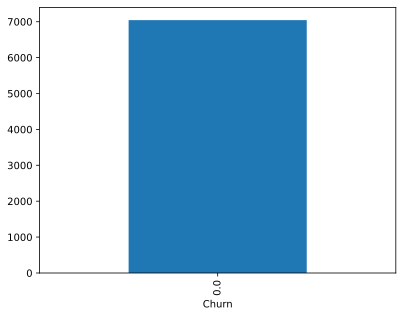

In [127]:
# Target Variable
finalCustData.Churn.value_counts(normalize = False).plot(kind = "bar")

In [128]:
finalCustData.Churn.value_counts(normalize = False)

Churn
0.0    7043
Name: count, dtype: int64

#### Model Building

#### 4. Build a neural-network model using PyTorch (or other library of your choice) to predict customer churn.

C:\Users\athorat\AppData\Local\anaconda3\envs\tf-new\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\athorat\AppData\Local\anaconda3\envs\tf-new\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\athorat\AppData\Local\anaconda3\envs\tf-new\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\athorat\AppData\Local\anaconda3\envs\tf-new\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated a

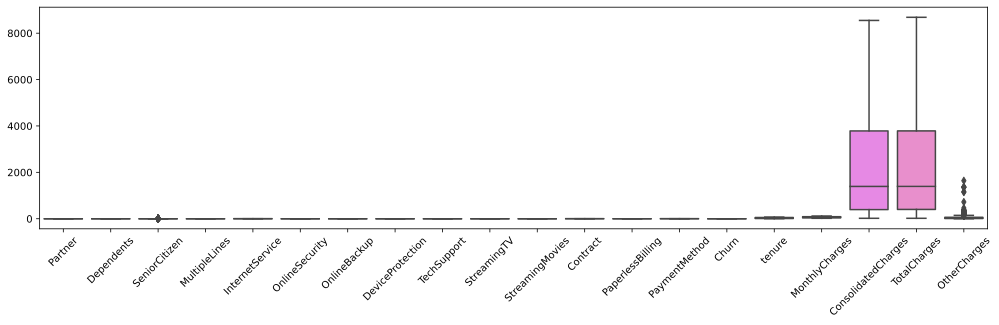

In [51]:
fig, ax = plt.subplots(1,figsize=(17,4))
ax = sns.boxplot(data=finalCustData)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

In [52]:
cols2zscore = finalCustData.keys()
cols2zscore = cols2zscore.drop('Churn')
finalCustData[cols2zscore] = finalCustData[cols2zscore].apply(stats.zscore)

finalCustData.describe()

TypeError: loop of ufunc does not support argument 0 of type float which has no callable sqrt method

In [ ]:
fig, ax = plt.subplots(1,figsize=(17,4))
ax = sns.boxplot(data=finalCustData)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

In [ ]:
# remove the rows with outlier data
finalCustData = finalCustData[finalCustData['OtherCharges']<5]

In [ ]:
fig, ax = plt.subplots(1,figsize=(17,4))
ax = sns.boxplot(data=finalCustData)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

In [ ]:
dataT = torch.tensor( finalCustData[cols2zscore].values).float()
labels = torch.tensor(finalCustData['Churn'].values ).float()

print(dataT.shape)
print(labels.shape)

labels = labels[:,None]
print(labels.shape)

#### 5. Split the data set in train (80%) and test (20%) sets. Train the model using the training set.

In [ ]:
def custData():
    
    # NEW: put all outputs into a dictionary
    output = {}
    output['data'] = torch.tensor( finalCustData[cols2zscore].values).float()
    output['labels'] = torch.tensor(finalCustData['Churn'].values ).float() # note: "long" format (integers) for labels
    
    # use scikitlearn to split the data
    trainData, testData,trainLabels,testLabels = train_test_split(output['data'], output['labels'],train_size=0.8)
    
    # then convert them into PyTorch Datasets (note: already converted to tensors)
    trainData = TensorDataset(trainData, trainLabels)
    testData = TensorDataset(testData, testLabels)
    
    # finally, translate into dataloader objects
    batchsize = 32
    output['trainLoader'] = DataLoader(trainData, batch_size = batchsize, shuffle=True,drop_last = True)
    output['testLoader']  = DataLoader(testData, batch_size=testData.tensors[0].shape[0])
    
    return output

In [ ]:
for X,y in trainLoader:
    print(X.shape, y.shape)

In [ ]:
class ANNcustData(nn.Module):
    def __init__(self):
        super().__init__()
        
        ## input layer
        self.input = nn.Linear(19,32)
    
        ## hidden layer
        self.fc1 = nn.Linear(32,42)
        self.bnorm1 = nn.BatchNorm1d(32)
        self.fc2 = nn.Linear(42,32)
        self.bnorm2 = nn.BatchNorm1d(42)
        self.fc3 = nn.Linear(32,20)
        self.bnorm3 = nn.BatchNorm1d(32)
    
        ## output layer
        self.output = nn.Linear(20,1)
    
    # forward pass
    def forward(self,x):
        
        # input layer without Batch Norm
        x = F.relu(self.input(x))
        
        # hidden layer 1
        x = self.bnorm1(x)
        x = self.fc1(x)
        x = F.relu(x)
        
        # hidden layer 2
        x = self.bnorm2(x)
        x = self.fc2(x)
        x = F.relu(x)
        
        # hidden layer 3
        x = self.bnorm3(x)
        x = self.fc3(x)
        x = F.relu(x)
        
        return self.output(x)

In [ ]:
def createChurnPredNet(nUnits,nLayers):
    
    class ANNcustData(nn.Module):
        def __init__(self,nUnits,nLayers):
            super().__init__()
            
            ## crete dictonary to store the layers
            self.layers = nn.ModuleDict()
            self.nLayers = nLayers

            ## input layer
            self.layers['input'] = nn.Linear(19,nUnits)
            
            ## hidden layers
            for i in range(1, nLayers):
                self.layers[f'hidden{i}'] = nn.Linear(nUnits,nUnits)
                self.layers[f'bnorm{i}']  = nn.BatchNorm1d(nUnits)
                
            ## output layers
            self.layers['output'] = torch.nn.Linear(nUnits,1,dtype = torch.float)


        # forward pass
        def forward(self,x):

            # input layer without Batch Norm
            x = self.layers['input'](x)

            # hidden layer
            for i in range(1,self.nLayers):
                #x = self.layers[f'bnorm{i}'](x)
                #x = self.layers[f'hidden{i}'](self.layers[f'bnorm{i}'](x))
                x = F.relu((self.layers[f'hidden{i}'](self.layers[f'bnorm{i}'](x))))
                #x = F.relu(torch.relu(self.layers[f'hidden{i}'](x)))
            
            # return output layer
            x = self.layers['output'](x)

            return x
        
    # create the model instance
    net = ANNcustData(nUnits,nLayers)
    
    # loss function
    #lossfun = nn.CrossEntropyLoss()
    lossfun = nn.BCELoss()
    #lossfun = F.cross_entropy
    
    # optimizer
    #optimizer = torch.optim.SGD(net.parameters(),lr=.01)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    
    #return net, lossfun
    return net, lossfun, optimizer

In [ ]:
# test the model with fake input

nUnitsPerLayer = 19
nLayers = 4

net,lossf,opt = createChurnPredNet(nUnitsPerLayer,nLayers)
#net,lossf = createChurnPredNet(nUnitsPerLayer,nLayers)
print(net)

# input is ten samples
input = torch.rand(19,19)
net(input)

In [ ]:
# a function to count the number of units
def countUnits(model):
    totalUnits = 0
    for layer in model.modules():
        if isinstance(layer, torch.nn.modules.linear.Linear):
            totalUnits += layer.in_features
    return totalUnits


nNodesInModel = 100
layersRange   = [ 1,5,10,20 ]

# print out the model architectures
for lidx,layers in enumerate(layersRange):

  # create a model
  unitsperlayer = int(nNodesInModel//layersRange[lidx])
  net = createChurnPredNet(unitsperlayer,layers)[0]

  # count and print the results
  print(f'Units/layer: {unitsperlayer}, layers: {layers}, Total count: {countUnits(net)}')

In [ ]:
# train the model

# global parameter
numepochs = 50

def lossfun(yHat,y):
    loss = F.cross_entropy(yHat,y)
    return loss

def trainTheModel(nUnits,nLayers):
    
    # create a new model
    net, lossfun, optimizer = createChurnPredNet(nUnits, nLayers)
        
    #initial losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []
    
    # loop over epocs
    for epochi in range(numepochs):
        
        #custDataSet.train()
        
        batchAcc = []
        batchLoss = []
        
        for X,y in train_data:
            
            yHat = net(X)
            loss = lossfun(yHat,y)
            
            #backdrop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # loss from this batch
            batchLoss.append(loss.sum().item())
            
            # compute accuracy
            matches = torch.argmax(yHat,axis=1) == y
            matchesNumeric = matches.float()
            accuracypct = 100*torch.mean(matchesNumeric)
            batchAcc.append( accuracypct )
                        
        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.mean(batchAcc) )
        
        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)
        
        # test accuracy
        custDataSet.eval()
        X,y = next(iter(test_data))
        with torch.no_grad():
            yHat = net(X)
        
        # compare the following really long line of code to the training accuracy lines
        testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )
        
    return trainAcc, testAcc, losses, net

In [ ]:
# before the experiment, configure and confirm the metaparameters

# specify the parameters for the model
nNodesInModel = 100
layersRange   = [ 1,5,10,20 ]
nDatapoints   = np.arange(50,551,50)

# create a legend for later plotting
legend = []

# print out the model architectures
for lidx,layers in enumerate(layersRange):

  # create a model
  unitsperlayer = int(nNodesInModel/layersRange[lidx])
  net = createChurnPredNet(unitsperlayer,layers)[0]

  # count its parameters
  nparams = np.sum([ p.numel() for p in net.parameters() if p.requires_grad ])

  legend.append( '%s layers, %s units, %s params' %(layers,unitsperlayer,nparams) )
  print('This model will have %s layers, each with %s units, totalling %s parameters' %(layers,unitsperlayer,nparams))


In [ ]:
# initialize results matrix
results = np.zeros((len(nDatapoints),len(layersRange),2))

for didx in enumerate(nDatapoints):
    
    # create data (note: same data for each layer manipulation!)
    theData = custData()
    train_data = theData['trainLoader']
    test_data  = theData['testLoader']
    
    # now loop over layers
    for lidx,layers in enumerate(layersRange):
        
        unitsperlayer = int(nNodesInModel/layersRange[lidx])
        trainAcc,testAcc,losses,net = trainTheModel(unitsperlayer,layers)
        
        # average of last 5 accuracies and losses
        results[didx,lidx,0] = np.mean( testAcc[-5:] )
        results[didx,lidx,1] = torch.mean(losses[-5:]).item()


In [ ]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(nDatapoints,results[:,:,1],'s-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Number of data points')
ax[0].legend(legend)
ax[0].set_title('Losses')

ax[1].plot(nDatapoints,results[:,:,0],'o-')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xlabel('Number of data points')
ax[1].set_title('Accuracy')
ax[1].legend(legend)
plt.show()

In [ ]:
# range of batch sizes
batchsizes = 2**np.arange(1,5,2)

#initialize output result matrics
accuracyResultsTrain = np.zeros((numepochs,len(batchsizes)))
accuracyResultsTest  = np.zeros((numepochs,len(batchsizes)))
comptime = np.zeros(len(batchsizes))

testLoader = DataLoader(testData, batch_size=testData.tensors[0].shape[0])

for bi in range(len(batchsizes)):
    starttime = time.process_time()
    
    trainLoader = DataLoader(trainData, batch_size = int(batchsizes[bi]), shuffle = True, drop_last = True)
    
    custDataSet = ANNcustData()
    trainAcc, testAcc, losses = trainTheModel()
    
    accuracyResultsTrain[:,bi] = trainAcc
    accuracyResultsTest[:,bi] = testAcc
    
    comptime[bi] = time.process_time() - starttime

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
plt.rcParams.update({'font.size': 12})

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train Accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test Accuracy')
plt.rcParams.update({'font.size': 12})

#common features
for i in range(2):
    ax[i].legend(batchsizes)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([50,100])
    ax[i].grid()

plt.show()
plt.rcParams.update({'font.size': 12})

In [ ]:
# bar plot of computation time
plt.bar(range(len(comptime)),comptime,tick_label=batchsizes)
plt.xlabel('Mini-batch size')
plt.ylabel('Computation time (s)')
plt.show()

In [ ]:
# range of batch sizes
#batchsizes = 2**np.arange(1,10,2)
#batchsize = 32
#numepochs = 10

#resultsDfs = []
#testAcc = []
#dfs = []

#for batch_size in batchsizes:
#    accuracyResultsTrain = np.zeros((numepochs,))
#    accuracyResuttsTest = np.zeros((numepochs,))
#    comptime = np.zeros((1,))
#    precisionResults = np.zeros((numepochs,))
#    recallResults = np.zeros((numepochs,))
#    f1Results = np.zeros((numepochs,))
    
#    testLoader = DataLoader(testData, batch_size=testData.tensors[0].shape[0])
    
#    starttime = time.process_time()
    
#    trainLoader = DataLoader(trainData, batch_size=int(batch_size), shuffle=True, drop_last=True)
    
#    custDataSet = ANNcustData()
    #trainAcc, testAcc, losses, precisionResults, recallResults, f1Results = trainTheModel()
#    trainAcc, testAccBatch, losses = trainTheModel()
    
    #testAcc = np.array(testAcc).reshape(numepochs, len(batchsizes))
    #accuracyResultsTest = np.zeros((numepochs, len(batchsizes)))
    
    #accuracyResultsTrain[:, 0] = trainAcc
    #accuracyResultsTest[:, 0] = testAcc
    
    # Append the batch-specific test accuracy values
 #   testAcc.append(testAccBatch)
       
 #   accuracyResultsTrain[:len(trainAcc)] = trainAcc
    #accuracyResultsTest[:len(testAcc)] = testAcc
    #accuracyResultsTest[:, 0] = testAcc[:, 0]
#    accuracyResultsTest[:, bi] = testAccBatch
#    comptime[0] = time.process_time() - starttime
    
#    yTrue = []
#    yPred = []
    
#    with torch.no_grad():
#        for X, y in testLoader:
#            yHat = custDataSet(X)
#            yPred.extend(((yHat > 0).cpu().numpy().flatten()))
#            yTrue.extend(y.cpu().numpy().flatten())
            
#    precisionResults[:len(precisionResults)] = precision_score(yTrue, yPred)
#    recallResults[:len(recallResults)] = recall_score(yTrue, yPred)
#    f1Results[:len(f1Results)] = f1_score(yTrue, yPred)
    
#    metrics_df = pd.DataFrame({
#        'Batch Size': [batchsizes[batch_size]] * numepochs,
#        'Epoch': np.arange(1, numepochs + 1),
#        'Accuracy': accuracyResultsTest[:,batch_size],
#        'Precision': precisionResults[batch_size],
#        'Recall': recallResults[batch_size],
#        'F1 Score': f1Results[batch_size]
#    })
    
#    dfs.append(metrics_df)
    
    # Ensure all arrays have the same length
    #num_epochs = len(trainAcc)
    #precisionResults = precisionResults[:num_epochs]
    #recallResults = recallResults[:num_epochs]
    #f1Results = f1Results[:num_epochs]
    
    #metricsDf = pd.DataFrame({
    #    'Batch Size': [batch_size],
    #    'Accuracy': accuracyResultsTest[-1,:],
    #    'Precision': precisionResults,
    #    'Recall': recallResults,
    #    'F1 Score': f1Results
    #})
    
    #resultsDfs.append(metricsDF)
    
    #comptime[0] = time.process_time() - starttime
    
#metrics_df = pd.concat(dfs, ignore_index=True)
#finalMetricDf = pd.concat(resultsDfs, ignore_index=True)
#print(metrics_df)

# Convert testAcc to a NumPy array and reshape it
#testAcc = np.array(testAcc).reshape(numepochs, len(batchsizes))


#initialize output result matrics
#accuracyResultsTrain = np.zeros((numepochs,len(batchsizes)))
#accuracyResultsTest  = np.zeros((numepochs,len(batchsizes)))
#comptime = np.zeros(len(batchsizes))

# batch size = 32
#accuracyResultsTrain = np.zeros((numepochs,1))
#accuracyResultsTest  = np.zeros((numepochs,1))
#comptime = np.zeros(1)

#precisionResults = []
#recallResults = []
#f1Results = []

#testLoader = DataLoader(testData, batch_size=testData.tensors[0].shape[0])

#for bi in range(len(batchsizes)):
#    starttime = time.process_time()
    
#    trainLoader = DataLoader(trainData, batch_size = int(batchsizes[bi]), shuffle = True, drop_last = True)
    
#    custDataSet = ANNcustData()
#    trainAcc, testAcc, losses, precisionResults, recallResults, f1Results = trainTheModel()
    
#    accuracyResultsTrain[:,bi] = trainAcc
#    accuracyResultsTest[:,bi] = testAcc
    
    # Ensure all arrays have the same length
#    num_batches = len(batchsizes)
#    batchsizes = batchsizes[:num_batches]
#    accuracyResultsTest = accuracyResultsTest[:, :num_batches]
    
#    metrics_df = pd.DataFrame({
#    'Batch Size': batchsizes,
#    'Accuracy': accuracyResultsTest[-1, :],
#    'Precision': precisionResults,
#    'Recall': recallResults,
#    'F1 Score': f1Results})
    
    # Print the table of metrics
#    print(metrics_df)

#starttime = time.process_time()
    
#trainLoader = DataLoader(trainData, batch_size=batchsize, shuffle=True, drop_last=True)
    
#custDataSet = ANNcustData()
#trainAcc, testAcc, losses, precisionResults, recallResults, f1Results = trainTheModel()
    
#accuracyResultsTrain[:,0] = trainAcc
#accuracyResultsTest[:,0] = testAcc
    
#metricsDf = pd.DataFrame({
#    'Batch Size': [batchsize],
#    'Accuracy': accuracyResultsTest[-1, :],
#    'Precision': precisionResults,
#    'Recall': recallResults,
#    'F1 Score': f1Results})
    
#Print the table of metrics
#print(metricsDf)

#comptime[0] = time.process_time() - starttime

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
plt.rcParams.update({'font.size': 12})

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train Accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test Accuracy')
plt.rcParams.update({'font.size': 12})

#common features
for i in range(2):
    ax[i].legend(batchsizes)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([50,100])
    ax[i].grid()

plt.show()
plt.rcParams.update({'font.size': 12})

In [ ]:
# bar plot of computation time
plt.bar(range(len(comptime)),comptime,tick_label=batchsizes)
plt.xlabel('Mini-batch size')
plt.ylabel('Computation time (s)')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

custDataSet.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for X, y in testLoader:
        yHat = custDataSet(X)
        y_pred.extend(((yHat > 0).cpu().numpy().flatten()))  # Convert predictions to numpy
        y_true.extend(y.cpu().numpy().flatten())  # Convert true labels to numpy

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate precision, recall, and F1 score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")